<a href="https://colab.research.google.com/github/IT21238994/24-25J-169-iTranz/blob/RouteModel_IT21298394/Route_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Installation and import libraries**

In [6]:
# Install required libraries
!pip install lightgbm shap imbalanced-learn
!pip install dask[dataframe]

# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

### **Import dataset & explore**

In [7]:
# Upload the dataset to Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset
file_path = 'bus_schedule_sept_nov_2024.csv'  # Replace with your actual file name if different
df = pd.read_csv(file_path)

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset Information:")
print(df.info())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

Saving bus_schedule_sept_nov_2024.csv to bus_schedule_sept_nov_2024.csv
First 5 rows of the dataset:
         Date     Day     Time  Route Traffic_Level  Delay (min)  \
0  01.09.2024  Sunday  8:00 AM    380        Medium            1   
1  01.09.2024  Sunday  4:40 PM    380           Low            0   
2  01.09.2024  Sunday  5:30 PM    356           Low            1   
3  01.09.2024  Sunday  3:10 PM    356           Low            1   
4  01.09.2024  Sunday  9:20 AM    380           Low            0   

   Distance (km)  Full Trip Time(min)  Average Speed (kmph)  \
0           10.9                   28                  31.4   
1           10.9                   28                  31.4   
2            9.2                   21                  32.5   
3            9.2                   21                  32.5   
4           10.9                   28                  31.4   

   Average Bus Stop Time(min)  Fare (LKR)  Seat_Availability (%)  \
0                         2.5          77  

### **Data preprocessing & cleaning**

In [8]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Since there are no missing values, proceed to feature engineering

# Convert categorical variables to string type if not already
for col in ['Traffic_Level', 'Day', 'Route']:
    df[col] = df[col].astype(str)

# Label encoding for categorical features
le_traffic = LabelEncoder()
le_day = LabelEncoder()
le_route = LabelEncoder()

df['Traffic_Level_Encoded'] = le_traffic.fit_transform(df['Traffic_Level'])
df['Day_Encoded'] = le_day.fit_transform(df['Day'])
df['Route_Encoded'] = le_route.fit_transform(df['Route'])

print("\nLabel Encoding completed for 'Traffic_Level', 'Day', and 'Route'.")



Missing Values in Each Column:
Date                           0
Day                            0
Time                           0
Route                          0
Traffic_Level                  0
Delay (min)                    0
Distance (km)                  0
Full Trip Time(min)            0
Average Speed (kmph)           0
Average Bus Stop Time(min)     0
Fare (LKR)                     0
Seat_Availability (%)          0
Historical_Peak_Delay (min)    0
dtype: int64

Label Encoding completed for 'Traffic_Level', 'Day', and 'Route'.


In [9]:
# Extract hour and minute from Time
def extract_time_features(time_str):
    try:
        time_obj = pd.to_datetime(time_str, format='%I:%M %p')
        return time_obj.hour, time_obj.minute
    except:
        return 12, 0  # Default to noon if parsing fails

df[['Hour', 'Minute']] = df['Time'].apply(lambda x: pd.Series(extract_time_features(x)))

# Represent Hour cyclically
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour']/24)

# Represent Minute cyclically
df['Minute_Sin'] = np.sin(2 * np.pi * df['Minute']/60)
df['Minute_Cos'] = np.cos(2 * np.pi * df['Minute']/60)

print("\nTemporal features extracted and cyclic representations created.")

# Interaction between Delay and Fare
df['Delay_Fare_Interaction'] = df['Delay (min)'] * df['Fare (LKR)']

# Interaction between Seat Availability and Fare
df['Seat_Fare_Interaction'] = df['Seat_Availability (%)'] * df['Fare (LKR)']

print("\nInteraction features created.")

# Square of Delay
df['Delay_Squared'] = df['Delay (min)'] ** 2

# Log transformation of Fare to reduce skewness
df['Fare_Log'] = np.log1p(df['Fare (LKR)'])

print("\nNon-linear features created.")


Temporal features extracted and cyclic representations created.

Interaction features created.

Non-linear features created.


Define the best_route correctly

In [10]:
# Convert 'Date' to datetime format and create 'Date_dt'
df['Date_dt'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
print("\n'Date_dt' column created from 'Date'.")

# Check if 'User_ID' exists; if not, create it based on 'Date_dt' and 'Time'
if 'User_ID' not in df.columns:
    # Create a synthetic 'User_Journey' by combining 'Date_dt' and 'Time'
    df['User_Journey'] = df['Date_dt'].astype(str) + "_" + df['Time']

    # Encode 'User_Journey' as numeric 'User_ID'
    le_journey = LabelEncoder()
    df['User_ID'] = le_journey.fit_transform(df['User_Journey'])

    print("\nSynthetic 'User_Journey' and 'User_ID' columns created based on 'Date_dt' and 'Time'.")
else:
    print("\n'User_ID' column already exists.")


'Date_dt' column created from 'Date'.

Synthetic 'User_Journey' and 'User_ID' columns created based on 'Date_dt' and 'Time'.


Verify Group Sizes

In [11]:
# Check the number of routes per group (Date_dt, Time, User_ID)
group_sizes = df.groupby(['Date_dt', 'Time', 'User_ID']).size()
print("\nNumber of routes per group:")
print(group_sizes.value_counts())

# Display how many groups have multiple routes
num_groups_multiple_routes = (group_sizes > 1).sum()
print(f"\nNumber of groups with multiple routes: {num_groups_multiple_routes}")

# If num_groups_multiple_routes == 0, it means each group has only one route
if num_groups_multiple_routes == 0:
    print("\nAll groups have only one route. Adjusting grouping strategy.")

    # Alternative grouping: Group by 'Date_dt' and 'Hour' to allow multiple routes within the same hour
    group_sizes_new = df.groupby(['Date_dt', 'Hour']).size()
    print("\nNumber of routes per new group (Date_dt, Hour):")
    print(group_sizes_new.value_counts())

    # Check how many new groups have multiple routes
    num_groups_multiple_routes_new = (group_sizes_new > 1).sum()
    print(f"\nNumber of new groups with multiple routes: {num_groups_multiple_routes_new}")

    if num_groups_multiple_routes_new == 0:
        print("\nNo groups have multiple routes even after adjusting grouping. The dataset may not contain multiple routes per hour.")
    else:
        print("\nProceeding with new grouping (Date_dt, Hour).")
else:
    print("\nProceeding with original grouping (Date_dt, Time, User_ID).")


Number of routes per group:
1    3380
2     273
Name: count, dtype: int64

Number of groups with multiple routes: 273

Proceeding with original grouping (Date_dt, Time, User_ID).


### **Define 'Best_Route' Based on New Grouping**

In [12]:
# Define weights for each factor
weight_delay = -0.4  # Negative weight as lower delay is better
weight_fare = -0.3   # Negative weight as lower fare is better
weight_seat = 0.3    # Positive weight as higher seat availability is better

# Create a composite score
df['Route_Score'] = (weight_delay * df['Delay (min)'] +
                     weight_fare * df['Fare (LKR)'] +
                     weight_seat * df['Seat_Availability (%)'])

# Normalize Route_Score
df['Route_Score_Normalized'] = (df['Route_Score'] - df['Route_Score'].min()) / (df['Route_Score'].max() - df['Route_Score'].min())

# Define 'Best_Route' as the route with the highest normalized score per group (Date_dt, Hour)
df['Best_Route'] = df.groupby(['Date_dt', 'Hour'])['Route_Score_Normalized']\
                     .transform(lambda x: (x == x.max()).astype(int))

print("\n'Redefined 'Best_Route' column based on the highest 'Route_Score_Normalized' per (Date_dt, Hour).")


'Redefined 'Best_Route' column based on the highest 'Route_Score_Normalized' per (Date_dt, Hour).


Verify 'Best_Route' Creation


Sample 'Best_Route' values:
     Date_dt  Hour Route  Route_Score_Normalized  Best_Route
0 2024-09-01     8   380                0.717718           0
1 2024-09-01    16   380                0.891892           1
2 2024-09-01    17   356                0.969970           1
3 2024-09-01    15   356                0.816817           0
4 2024-09-01     9   380                0.756757           0
5 2024-09-01    12   356                0.684685           0
6 2024-09-01    11   380                0.759760           0
7 2024-09-01    11   356                0.972973           1
8 2024-09-01    15   380                0.855856           0
9 2024-09-01    10   380                0.879880           0

Number of groups with zero Best_Route: 0

Class Distribution for 'Best_Route':
Best_Route
0    2663
1    1263
Name: count, dtype: int64


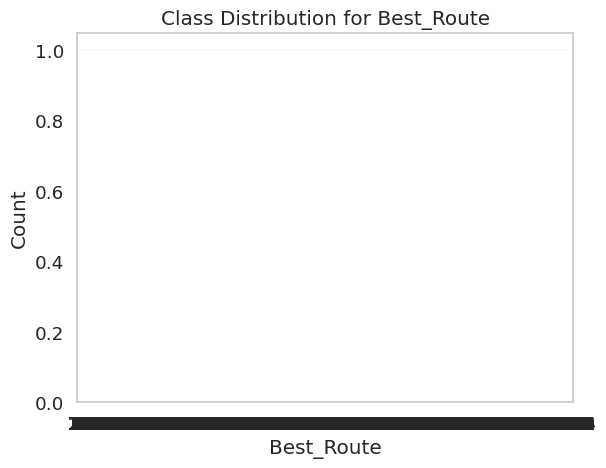

In [13]:
# Display the first few rows to verify 'Best_Route'
print("\nSample 'Best_Route' values:")
print(df[['Date_dt', 'Hour', 'Route', 'Route_Score_Normalized', 'Best_Route']].head(10))

# Check if any group has zero Best_Route
group_counts = df.groupby(['Date_dt', 'Hour'])['Best_Route'].sum()
zero_best_routes = (group_counts == 0).sum()
print(f'\nNumber of groups with zero Best_Route: {zero_best_routes}')

# If any groups have zero Best_Route, handle them by assigning the first route as best
if zero_best_routes > 0:
    print(f"\nHandling {zero_best_routes} groups with zero Best_Route.")
    df.loc[df.groupby(['Date_dt', 'Hour'])['Best_Route'].transform('sum') == 0, 'Best_Route'] = 1
    print("Assigned 'Best_Route' as 1 for these groups.")

# Re-check class distribution
print("\nClass Distribution for 'Best_Route':")
print(df['Best_Route'].value_counts())

# Plot class distribution
sns.countplot(df['Best_Route'])
plt.title('Class Distribution for Best_Route')
plt.xlabel('Best_Route')
plt.ylabel('Count')
plt.show()

Feature Selection and Model Preparation

In [14]:
# Define feature columns (exclude 'Best_Route' and other non-predictive columns)
feature_cols = [
    'Traffic_Level_Encoded', 'Day_Encoded', 'Route_Encoded', 'Hour_Sin', 'Hour_Cos',
    'Minute_Sin', 'Minute_Cos', 'Delay (min)', 'Distance (km)', 'Full Trip Time(min)',
    'Average Speed (kmph)', 'Average Bus Stop Time(min)', 'Fare (LKR)',
    'Seat_Availability (%)', 'Historical_Peak_Delay (min)', 'Hour',
    'Delay_Fare_Interaction', 'Seat_Fare_Interaction', 'Delay_Squared',
    'Fare_Log'
]

# Define features (X) and target (y)
X = df[feature_cols]
y = df['Best_Route']

print("\nFeature columns and target variable defined.")

# Feature Scaling
scaler = StandardScaler()
numerical_features = ['Delay (min)', 'Distance (km)', 'Seat_Availability (%)',
                      'Historical_Peak_Delay (min)', 'Fare (LKR)',
                      'Delay_Fare_Interaction', 'Seat_Fare_Interaction',
                      'Delay_Squared', 'Fare_Log']

X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\nFeature scaling applied to numerical features.")


Feature columns and target variable defined.

Feature scaling applied to numerical features.


### **Split the Data into Training and Testing Sets**

In [15]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nData split into training and testing sets.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")



Data split into training and testing sets.
Training set size: 3140 samples
Testing set size: 786 samples



Class Distribution in Training Set Before SMOTE:
Best_Route
0    2130
1    1010
Name: count, dtype: int64


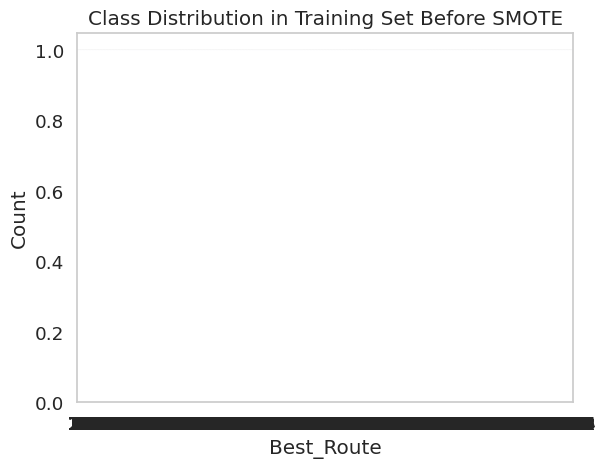

In [16]:
######### Handle Class Imbalance with SMOTE


# Check class distribution in the training set
print("\nClass Distribution in Training Set Before SMOTE:")
print(y_train.value_counts())

# Plot class distribution
sns.countplot(y_train)
plt.title('Class Distribution in Training Set Before SMOTE')
plt.xlabel('Best_Route')
plt.ylabel('Count')
plt.show()


Class Distribution After SMOTE:
Best_Route
0    2130
1    2130
Name: count, dtype: int64


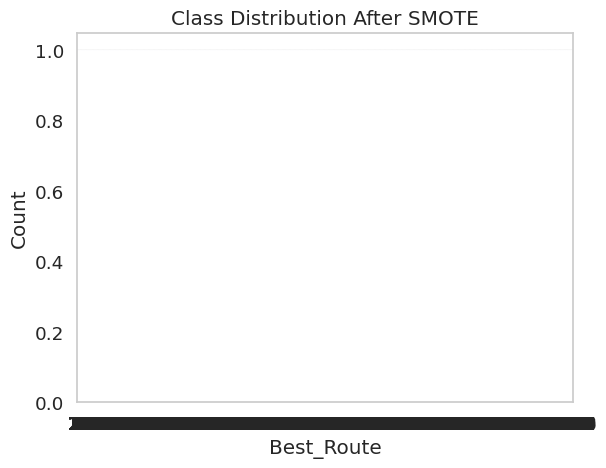

In [17]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_res).value_counts())

# Plot the new class distribution
sns.countplot(y_train_res)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Best_Route')
plt.ylabel('Count')
plt.show()

### **Train the LightGBM Model**

In [18]:
# Define LightGBM parameters
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train_res, label=y_train_res)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the LightGBM model without early stopping
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data]
)


### **Model Evaluation**

In [19]:
# Predict probabilities on the test set
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.8473
ROC-AUC: 0.9220

Confusion Matrix:
[[463  70]
 [ 50 203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       533
           1       0.74      0.80      0.77       253

    accuracy                           0.85       786
   macro avg       0.82      0.84      0.83       786
weighted avg       0.85      0.85      0.85       786



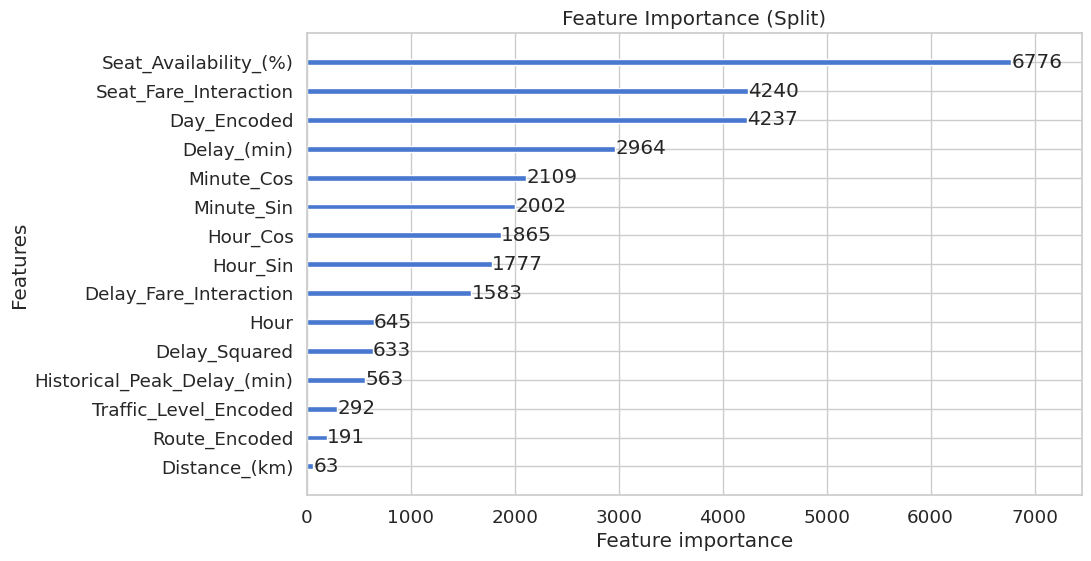

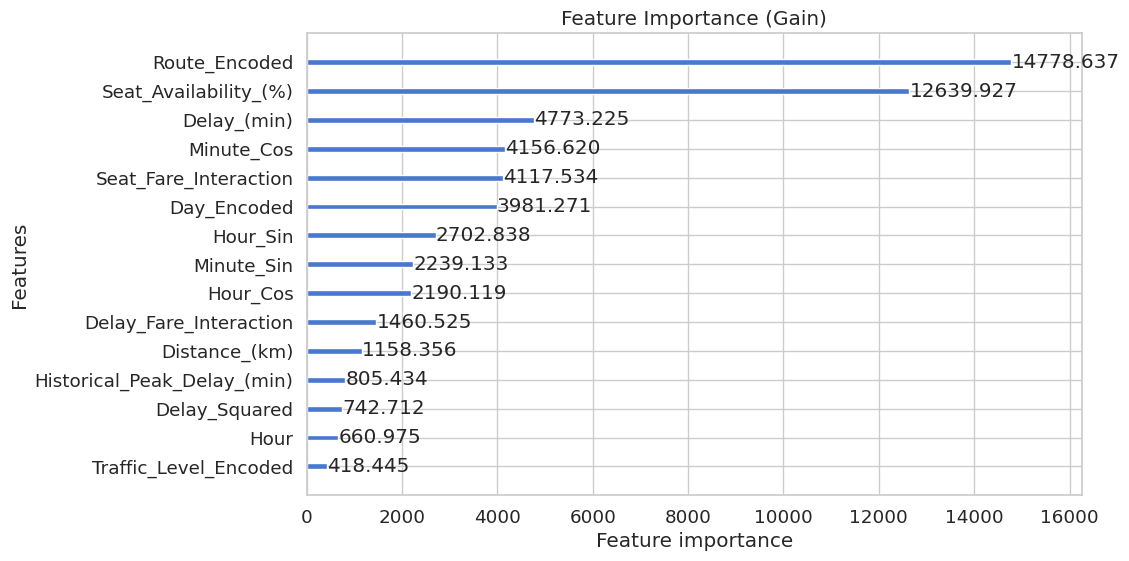

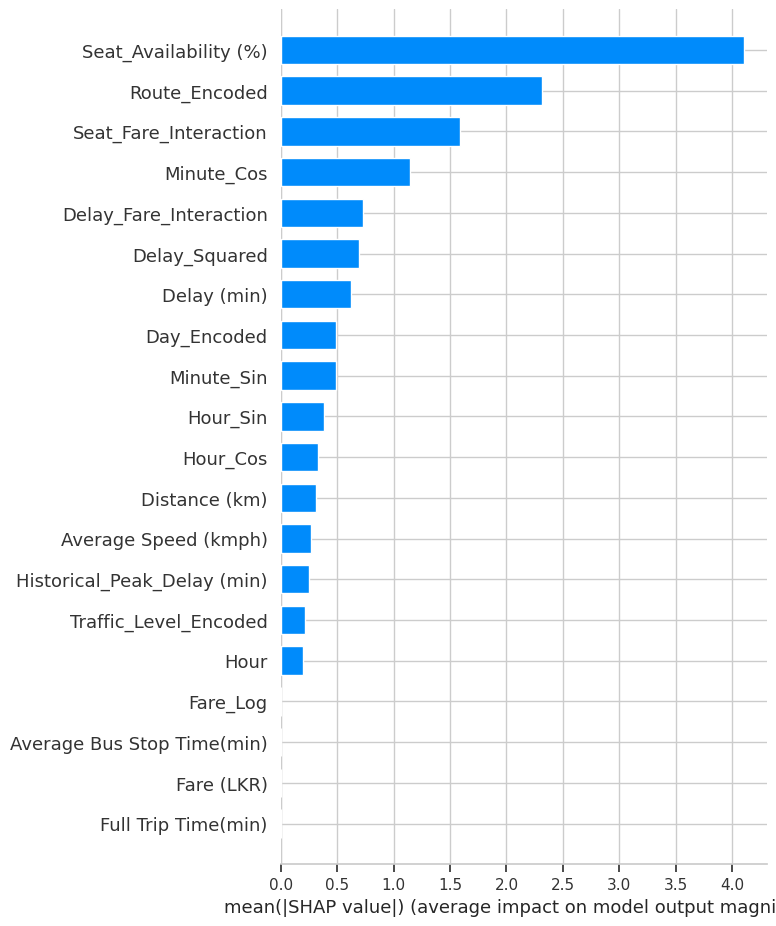

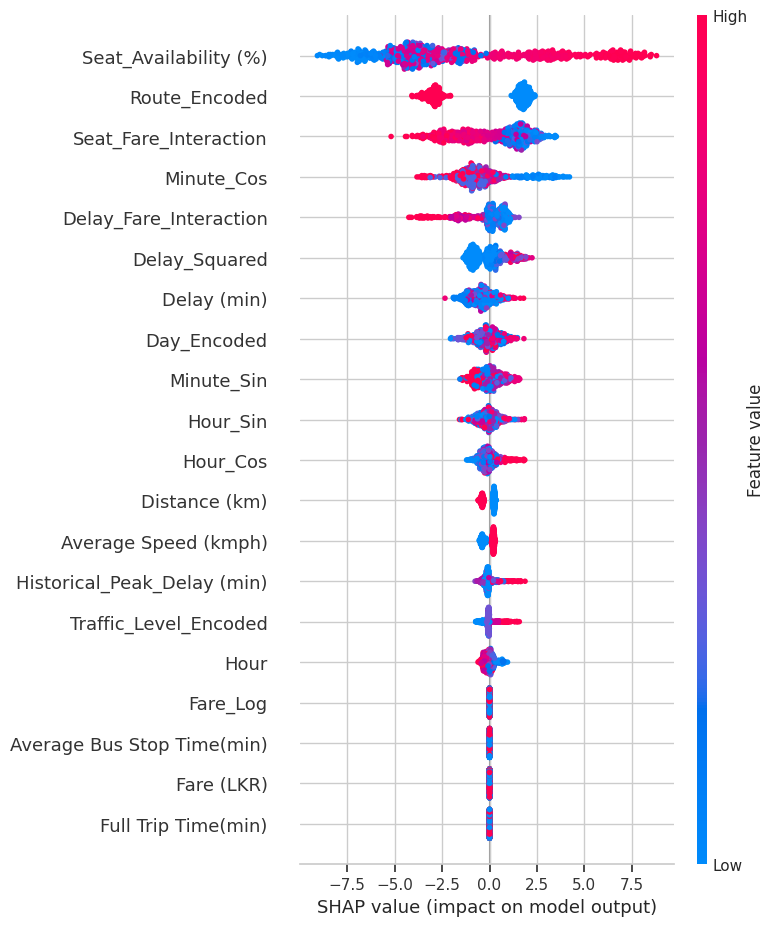

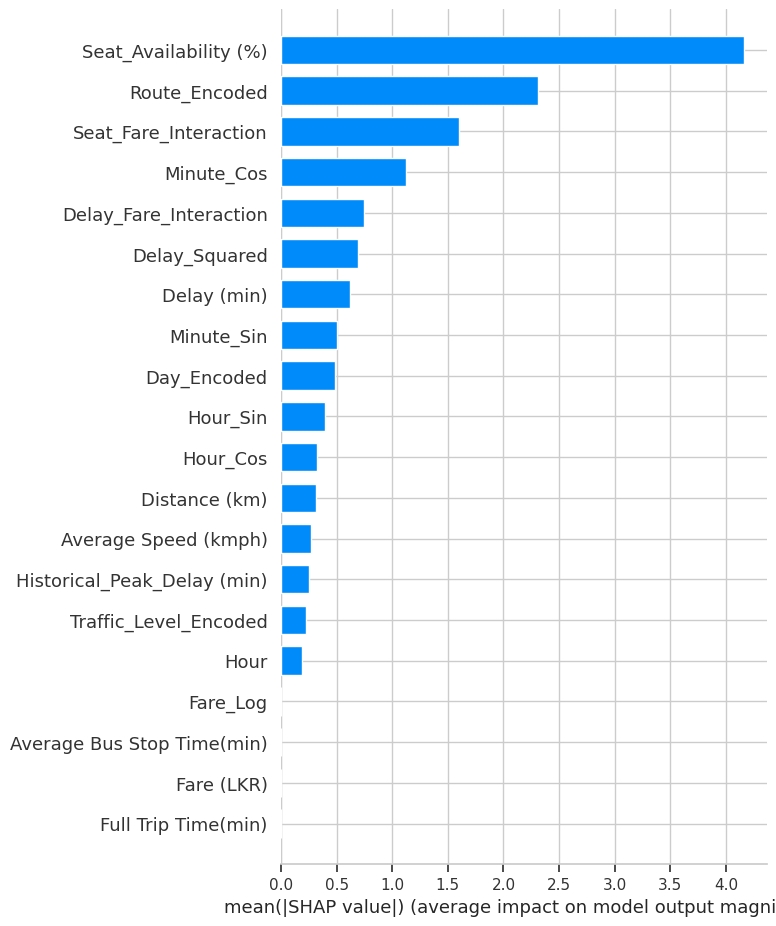

In [20]:
############# Feature Importance and SHAP Analysis


# Feature importance based on split
lgb.plot_importance(gbm, max_num_features=15, importance_type='split', figsize=(10,6))
plt.title('Feature Importance (Split)')
plt.show()

# Feature importance based on gain
lgb.plot_importance(gbm, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title('Feature Importance (Gain)')
plt.show()

# SHAP Analysis
# Initialize SHAP explainer
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP Summary Plot (Dot)
shap.summary_plot(shap_values, X_test)

# If performance is an issue, sample a subset
sample_indices = np.random.choice(X_test.index, size=500, replace=False)
shap_values_sample = explainer.shap_values(X_test.loc[sample_indices])

# SHAP Summary Plot for the sample
shap.summary_plot(shap_values_sample, X_test.loc[sample_indices], plot_type="bar")

In [21]:
##############################
##  Save the Trained Model  ##
##############################


# Save the LightGBM model to a file
gbm.save_model('lightgbm_best_bus_route_model.txt')
print("\nLightGBM model saved as 'lightgbm_best_bus_route_model.txt'.")

# To load the model later:
# gbm_loaded = lgb.Booster(model_file='lightgbm_best_bus_route_model.txt')
# sample = X_test.iloc[:5]
# sample_pred_prob = gbm_loaded.predict(sample, num_iteration=gbm_loaded.best_iteration)
# print(sample_pred_prob)


LightGBM model saved as 'lightgbm_best_bus_route_model.txt'.
